# Notebook for running 1D-TDSE C code from Python
Author: Tadeas Nemec, 2023

### Load libraries and files

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
### Main Python TDSE helper script, contains C structures, function wrappers etc.
from PythonTDSE import *

### Path to compiled dynamic C library
path_to_DLL = os.path.realpath(os.path.join(os.getcwd(), "singleTDSE.so"))
DLL = CDLL(path_to_DLL)

### TDSE variables initialization

We instantiate a C-compatible ```inputs_def``` class that is in fact C types structure. This strucure (class) contains all the necessary variables for the C 1D-TDSE code. Then we initialize it from an HDF5 input file.

In [2]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def
filename = "results.h5"
inputs.init_inputs(filename)
inputs.init_prints(path_to_DLL)

Initialize temporal grid and initial field. There are two ways how to do it. Either you specify the result file from the CUPRAD code and select a particular field or you provide custom electric field and time grids.

In [3]:
### Set indeces in the field:
z_i = 75
r_i = 512
### Initialize field and time in the input
inputs.init_time_and_field(filename, z_i, r_i)

We can visualize and check the fields by plotting.

We use function ```ctype_arr_to_numpy``` for conversion of the Ctypes array into Numpy array.

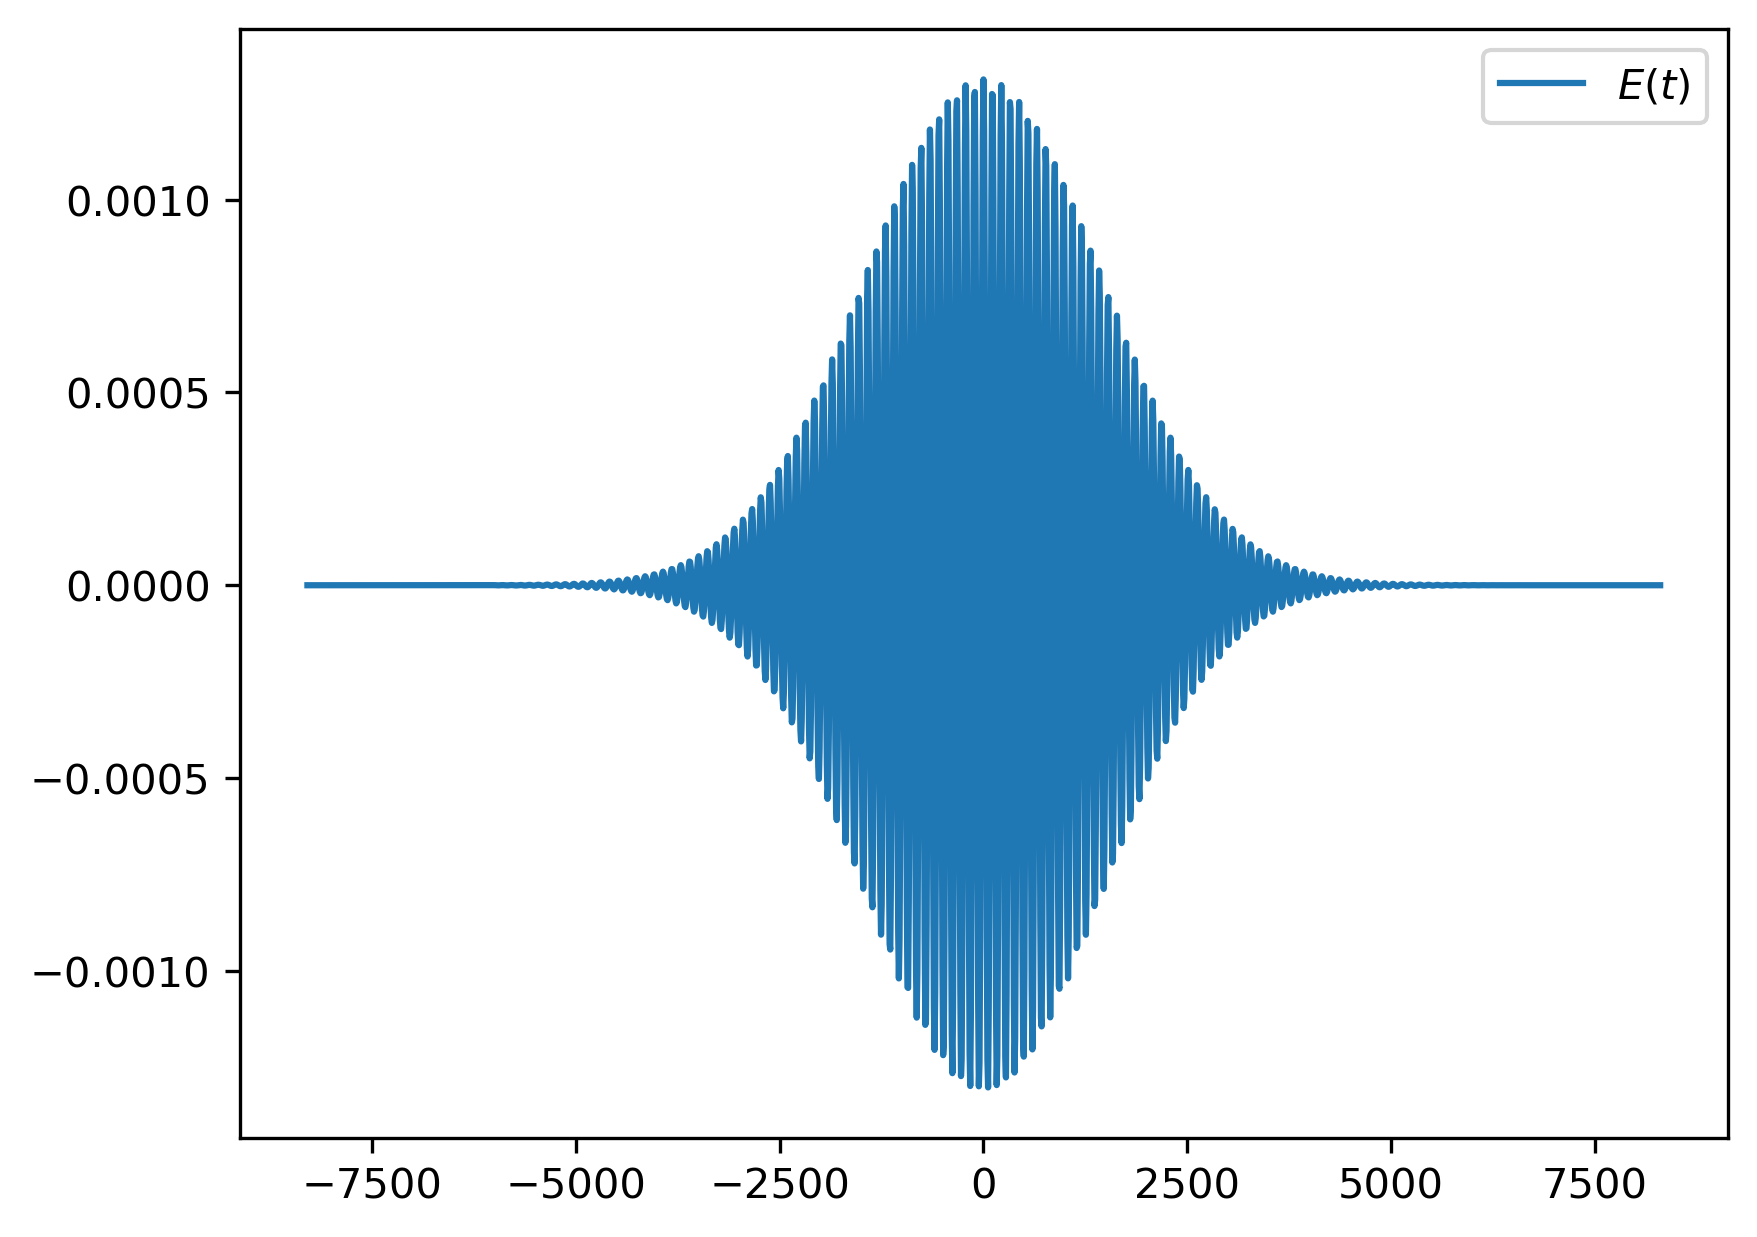

In [4]:
fig = plt.figure()
fig.dpi = 300
N = inputs.Efield.Nt
E = ctype_arr_to_numpy(inputs.Efield.Field, N)
t = ctype_arr_to_numpy(inputs.Efield.tgrid, N)
plt.plot(t, E, label = r"$E(t)$")
plt.legend()
plt.show()

### Ground state computation

We need to first compute the ground state (GS) wavefunction for the propagation. We call the C function ```Initialise_grid_and_ground_state``` and pass the pointer to ```inputs``` using Ctypes function ```byref```. This is conveniently encapsulated in the ```init_GS``` function. We need to include the path to the C library.

**Note**: it prints the progress of the GS energy computation.

In [5]:
init_GS(inputs, path_to_DLL)

cv : 9.955182e-01 Energy : -4.481760e-03
cv : 7.627079e-03 Energy : -1.210884e-02
cv : 2.920607e-02 Energy : -4.131491e-02
cv : 9.274418e-02 Energy : -1.340591e-01
cv : 1.719478e-01 Energy : -3.060069e-01
cv : 1.366361e-01 Energy : -4.426430e-01
cv : 5.269427e-02 Energy : -4.953372e-01
cv : 1.443221e-02 Energy : -5.097695e-01
cv : 3.560541e-03 Energy : -5.133300e-01
cv : 8.574452e-04 Energy : -5.141874e-01
cv : 2.063240e-04 Energy : -5.143938e-01
cv : 5.014898e-05 Energy : -5.144439e-01
cv : 1.248187e-05 Energy : -5.144564e-01
cv : 3.263059e-06 Energy : -5.144597e-01
cv : 9.356698e-07 Energy : -5.144606e-01
cv : 3.104625e-07 Energy : -5.144609e-01
cv : 1.228240e-07 Energy : -5.144610e-01
cv : 5.669224e-08 Energy : -5.144611e-01
cv : 2.896132e-08 Energy : -5.144611e-01
cv : 1.562425e-08 Energy : -5.144611e-01
cv : 8.651736e-09 Energy : -5.144611e-01
cv : 4.847246e-09 Energy : -5.144611e-01
cv : 2.729181e-09 Energy : -5.144611e-01
cv : 1.539990e-09 Energy : -5.144612e-01
cv : 8.692222e-1

We can check if the GS has been found by plotting it.

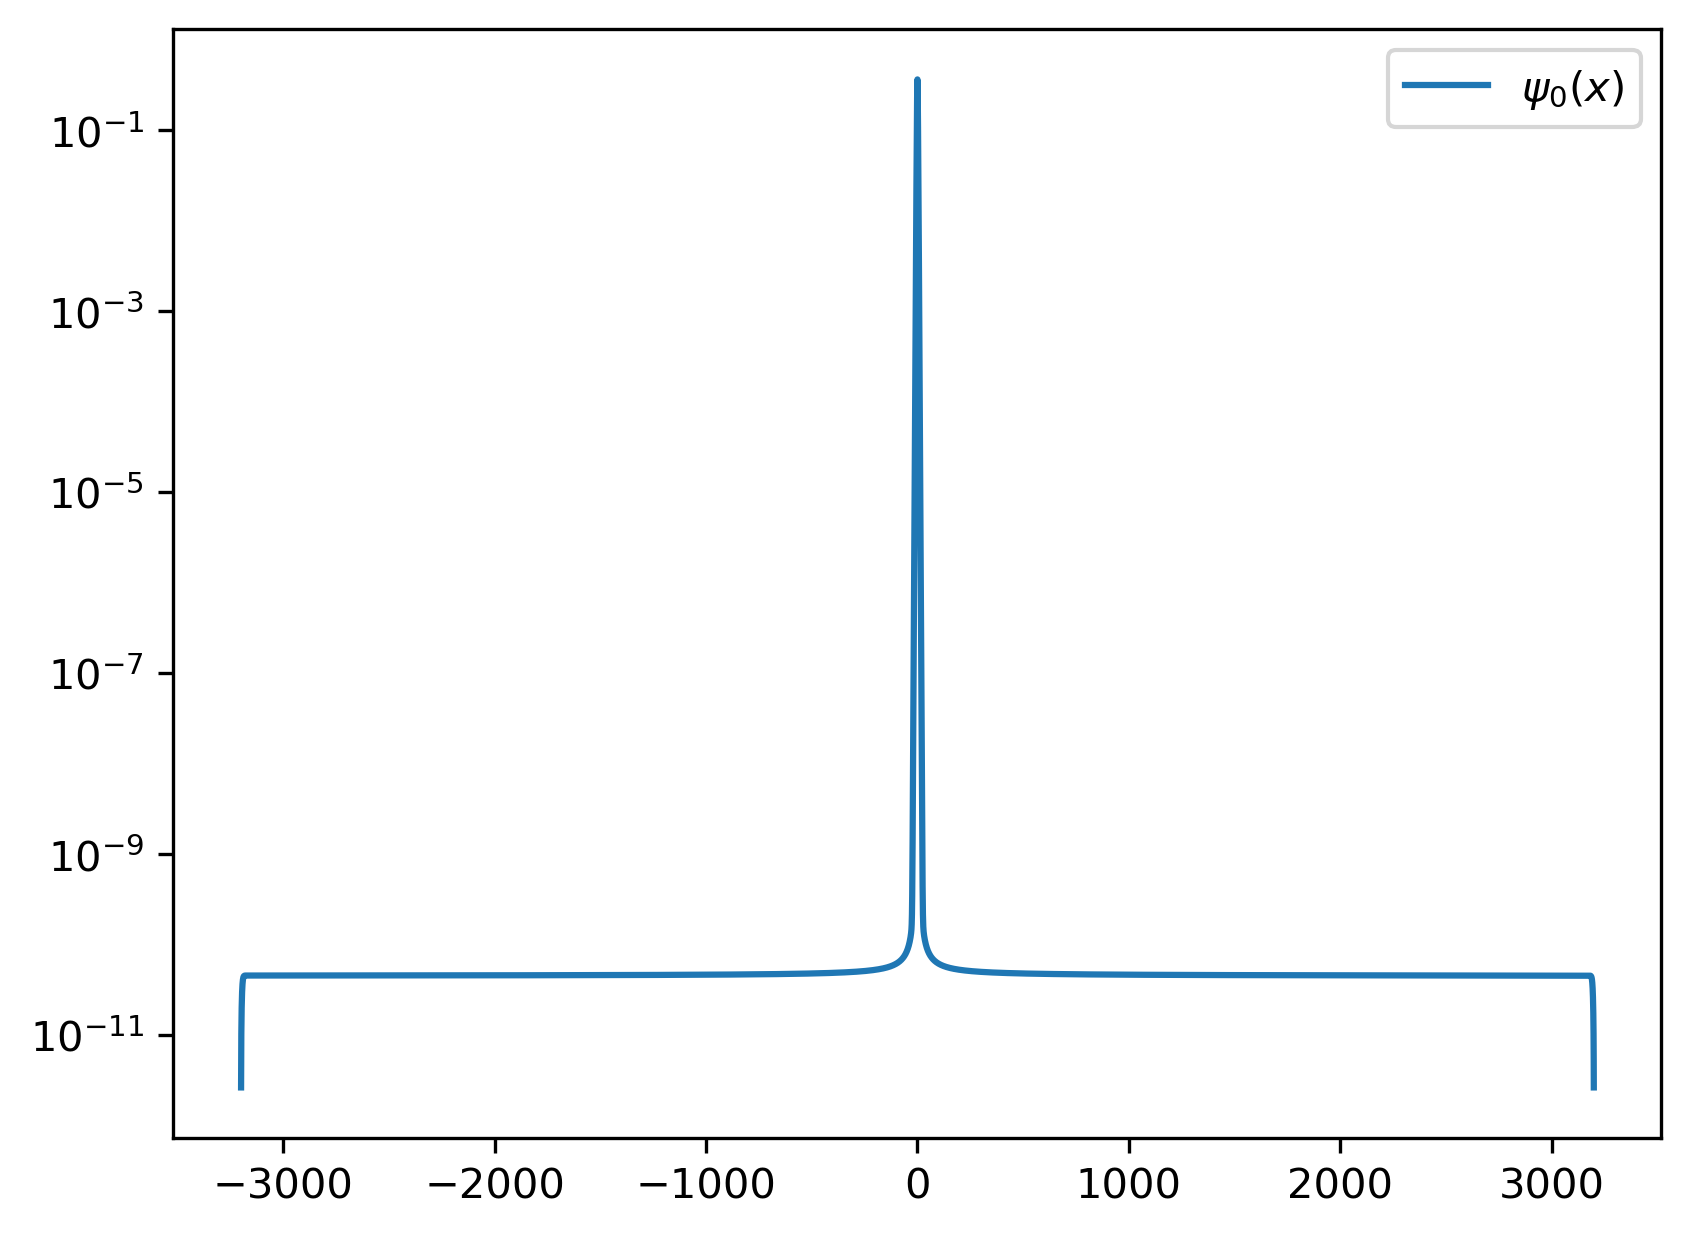

In [7]:
fig = plt.figure()
fig.dpi = 300
psi0 = ctype_arr_to_numpy(inputs.psi0, 2*(inputs.num_r+1))
x = ctype_arr_to_numpy(inputs.x, inputs.num_r+1)
plt.semilogy(x, np.abs(psi0)[0:-1:2], label = r"$\psi_0(x)$")
plt.legend()
plt.show()

### Propagation of the wavefunction

Now that we have found the GS, we can run the 1D-TDSE. We first define the output structure of type ```outputs_def``` that will store the result of the TDSE computation. 

**Remark**: This part of the code is computationally heavy and may take several minutes to finish, depending on the size of the input field. 

In [7]:
output = outputs_def()
### Call 1D TDSE from the inputs
output = call1DTDSE(inputs, path_to_DLL)

We may now plot the result of the computation. We can try plotting the expectation value of x, $<x(t)>$, during the propagation.

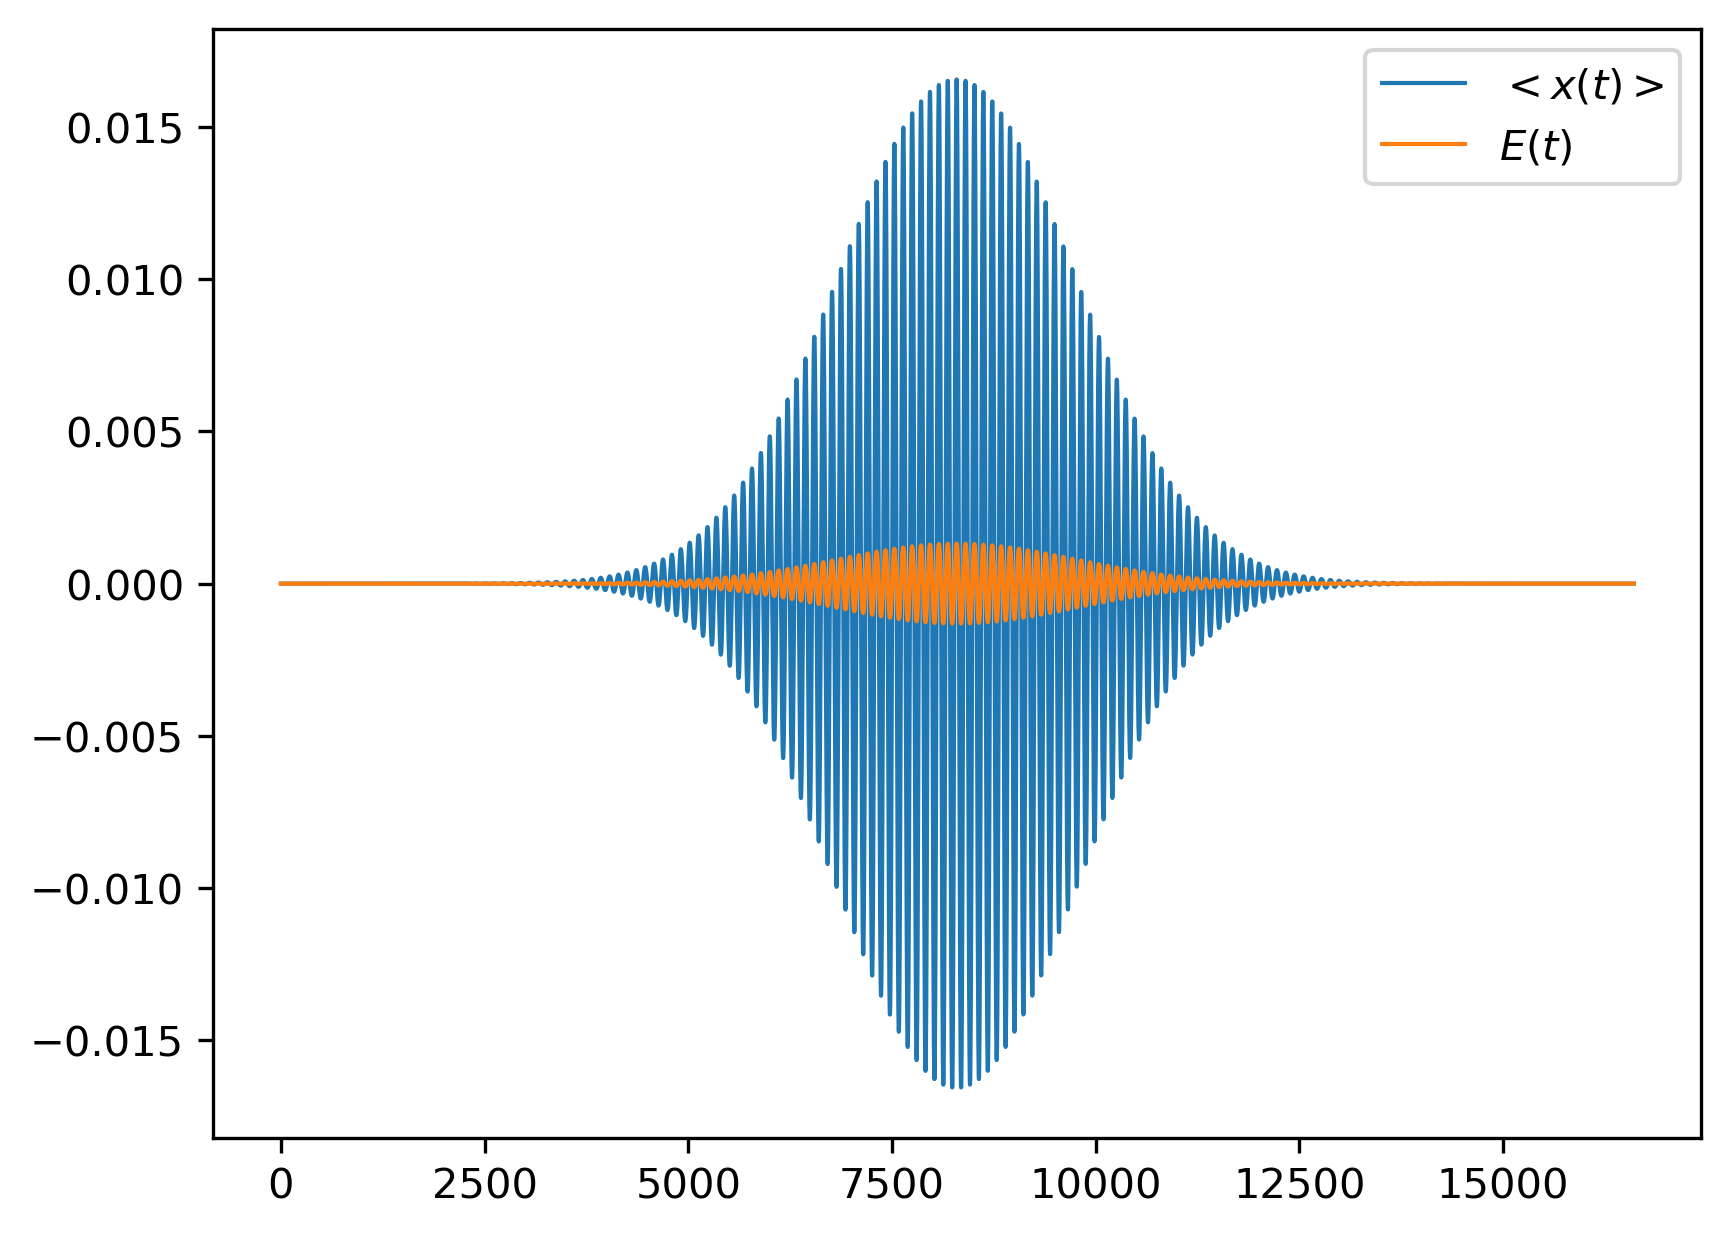

In [10]:
fig = plt.figure()
fig.dpi = 300
N = output.Nt
t = ctype_arr_to_numpy(output.tgrid, N)
x = ctype_arr_to_numpy(output.expval, N)
E = ctype_arr_to_numpy(output.Efield, N)
plt.plot(t, x, label = r"$<x(t)>$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1)
plt.legend()
plt.show()